In [14]:
# === 1) SETTINGS + EXTRACT ALL FRAMES (reports FPS & frame count) ===
# pip install opencv-python mediapipe matplotlib

import cv2
import os
from pathlib import Path

# 👉 Change this to your video path
VIDEO_PATH = r"C:\Users\yenul\PycharmProjects\YOLO_speed_tracker\output_masked3.mp4"

RAW_DIR = "exported_frames_raw"
os.makedirs(RAW_DIR, exist_ok=True)

# (Optional) clean previous raw frames
for f in Path(RAW_DIR).glob("*.png"):
    try: f.unlink()
    except Exception as e: print("Warn:", e)

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Failed to open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS) or 0.0
w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)  or 0)
h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) or 0)

frame_idx = 0
while True:
    ok, frame = cap.read()
    if not ok:
        break
    frame_idx += 1
    cv2.imwrite(str(Path(RAW_DIR)/f"frame_{frame_idx:06d}.png"), frame)

cap.release()

print(f"Video path       : {VIDEO_PATH}")
print(f"Resolution (wxh) : {w} x {h}")
print(f"FPS (metadata)   : {fps:.3f}")
print(f"Frames extracted : {frame_idx}")


Video path       : C:\Users\yenul\PycharmProjects\YOLO_speed_tracker\output_masked3.mp4
Resolution (wxh) : 1920 x 1080
FPS (metadata)   : 30.000
Frames extracted : 87


In [15]:
# === 2) AUTO-CROP ALL FRAMES (saves to CROPPED_DIR) ===
import cv2
import numpy as np
from pathlib import Path
import os
import math

RAW_DIR     = "exported_frames_raw"
CROPPED_DIR = "exported_frames_cropped2"
os.makedirs(CROPPED_DIR, exist_ok=True)

# (Optional) clean previous cropped frames
for f in Path(CROPPED_DIR).glob("*.png"):
    try: f.unlink()
    except Exception as e: print("Warn:", e)

def auto_crop(img, pad_frac=0.02, min_area_ratio=0.01):
    """
    Find the largest bright/non-black region and crop to its bounding box.
    pad_frac: extra margin around the box (fraction of max(w,h)).
    min_area_ratio: ignore tiny blobs (< this ratio of full frame).
    """
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Otsu threshold: separates dark background from brighter content
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Clean up mask a bit
    k = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=2)

    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return img, (0,0,w,h)  # fallback

    # take the largest contour (assumed to be the bright window/content)
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    if area < (w*h*min_area_ratio):
        return img, (0,0,w,h)  # too small, ignore

    x, y, bw, bh = cv2.boundingRect(c)
    pad = int(round(max(bw, bh) * pad_frac))

    x0 = max(0, x - pad)
    y0 = max(0, y - pad)
    x1 = min(w, x + bw + pad)
    y1 = min(h, y + bh + pad)

    return img[y0:y1, x0:x1], (x0, y0, x1, y1)

raw_files = sorted(Path(RAW_DIR).glob("*.png"))
if not raw_files:
    raise RuntimeError(f"No frames found in {RAW_DIR}. Run Cell 1 first.")

saved = 0
for i, fp in enumerate(raw_files, start=1):
    img = cv2.imread(str(fp))
    if img is None:
        continue
    cropped, bbox = auto_crop(img, pad_frac=0.02)
    cv2.imwrite(str(Path(CROPPED_DIR)/f"crop_{i:06d}.png"), cropped)
    saved += 1

print(f"Cropped {saved} frames → '{CROPPED_DIR}'")


Cropped 87 frames → 'exported_frames_cropped2'


Cropped frames scanned   : 87
Frames with pose found   : 86


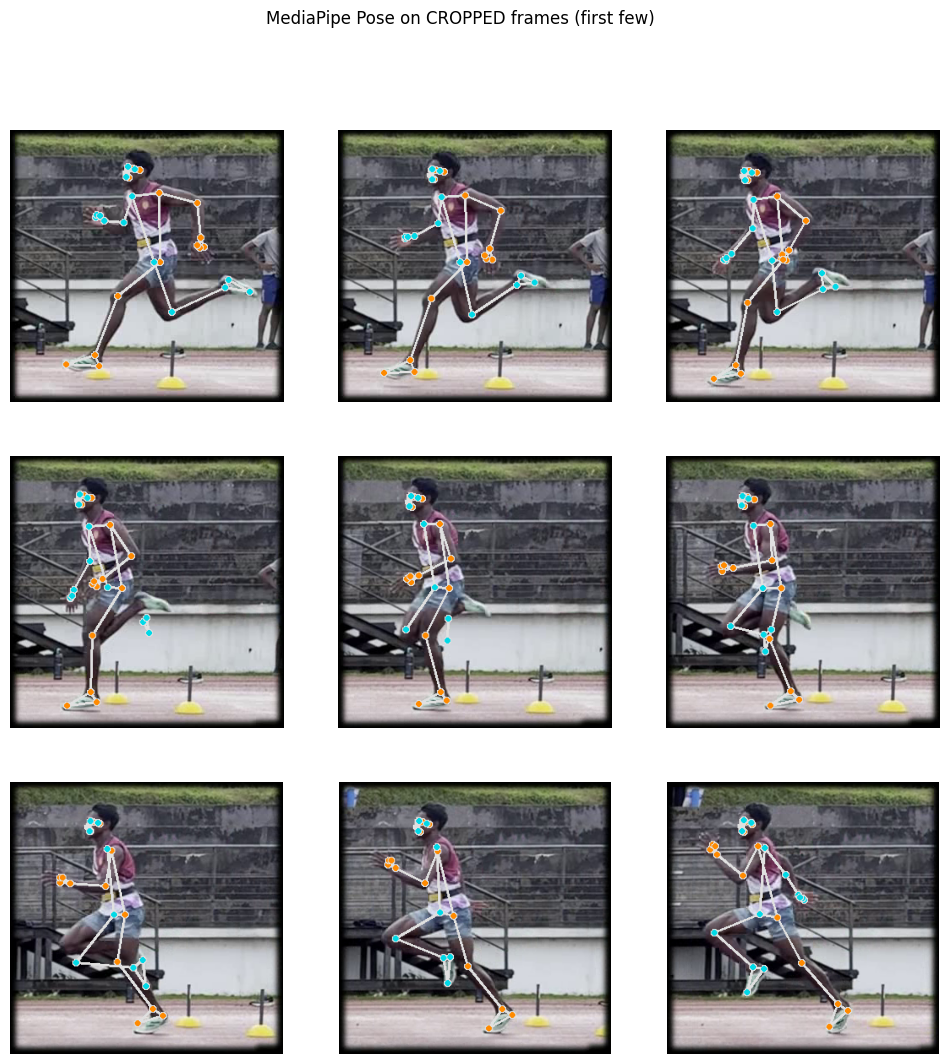

In [16]:
# === 3) MEDIAPIPE POSE ON CROPPED FRAMES + PREVIEW ===
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

try:
    import mediapipe as mp
except ImportError as e:
    raise ImportError("MediaPipe not found. Please run: pip install mediapipe") from e

CROPPED_DIR = "exported_frames_cropped2"

mp_pose  = mp.solutions.pose
mp_draw  = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles

pose = mp_pose.Pose(
    static_image_mode=True,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5
)

files = sorted(Path(CROPPED_DIR).glob("*.png"))
if not files:
    raise RuntimeError(f"No cropped frames found in {CROPPED_DIR}. Run Cell 2 first.")

processed = 0
previews = []

for idx, fp in enumerate(files):
    img = cv2.imread(str(fp))
    if img is None:
        continue
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res = pose.process(rgb)

    if res.pose_landmarks:
        mp_draw.draw_landmarks(
            img, res.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_style.get_default_pose_landmarks_style()
        )
        processed += 1

    if idx < 9:
        previews.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

pose.close()

print(f"Cropped frames scanned   : {len(files)}")
print(f"Frames with pose found   : {processed}")

if previews:
    cols = 3
    rows = math.ceil(len(previews)/cols)
    plt.figure(figsize=(12, rows*4))
    for i, im in enumerate(previews, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(im); plt.axis("off")
    plt.suptitle("MediaPipe Pose on CROPPED frames (first few)")
    plt.show()


In [17]:
# === 4) SAVE ALL POSE-OVERLAID CROPPED FRAMES ===
import cv2
import os
from pathlib import Path

try:
    import mediapipe as mp
except ImportError as e:
    raise ImportError("MediaPipe not found. Please run: pip install mediapipe") from e

CROPPED_DIR = "exported_frames_cropped2"
OUT_DIR     = "exported frames with mp2"

os.makedirs(OUT_DIR, exist_ok=True)
for f in Path(OUT_DIR).glob("*.png"):
    try: f.unlink()
    except Exception as e: print("Warn:", e)

mp_pose  = mp.solutions.pose
mp_draw  = mp.solutions.drawing_utils
mp_style = mp.solutions.drawing_styles

pose = mp_pose.Pose(
    static_image_mode=True,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5
)

files = sorted(Path(CROPPED_DIR).glob("*.png"))
if not files:
    raise RuntimeError(f"No cropped frames found in {CROPPED_DIR}. Run Cell 2 first.")

saved = 0
for idx, fp in enumerate(files, start=1):
    img = cv2.imread(str(fp))
    if img is None:
        continue
    res = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if res.pose_landmarks:
        mp_draw.draw_landmarks(
            img, res.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_style.get_default_pose_landmarks_style()
        )
    cv2.imwrite(str(Path(OUT_DIR)/f"mp_{idx:06d}.png"), img)
    saved += 1

pose.close()
print(f"Saved {saved} processed frames → '{OUT_DIR}'")


Saved 87 processed frames → 'exported frames with mp2'


In [18]:
# === BUILD SKELETON-ONLY PNGs (transparent background) FROM CROPPED FRAMES ===
import os
from pathlib import Path
import cv2
import numpy as np

try:
    import mediapipe as mp
except ImportError as e:
    raise ImportError("MediaPipe not found. Please run: pip install mediapipe") from e

# Input: your cropped frames from previous step
CROPPED_DIR = "exported_frames_cropped2"

# Output: skeleton-only frames (transparent background)
SKEL_DIR = "exported frames mp sketch only"
os.makedirs(SKEL_DIR, exist_ok=True)

# (Optional) clean previous outputs
for f in Path(SKEL_DIR).glob("*.png"):
    try: f.unlink()
    except Exception as e: print("Warn:", e)

# Drawing params
VIS_THRESH = 0.30       # only draw landmarks/segments if visibility is above this
LINE_SCALE = 150        # thickness ~ min(H,W) / LINE_SCALE
DOT_SCALE  = 250        # dot radius ~ min(H,W) / DOT_SCALE
SKEL_RGB   = (255, 255, 255)  # white lines/dots

mp_pose = mp.solutions.pose
POSE_CONNECTIONS = mp_pose.POSE_CONNECTIONS

pose = mp_pose.Pose(
    static_image_mode=True,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5
)

files = sorted(Path(CROPPED_DIR).glob("*.png"))
if not files:
    raise RuntimeError(f"No cropped frames found in '{CROPPED_DIR}'. Run your crop step first.")

saved = 0
for i, fp in enumerate(files, start=1):
    img = cv2.imread(str(fp))
    if img is None:
        continue
    h, w = img.shape[:2]

    # run pose
    res = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # create empty alpha mask to draw the sketch
    alpha = np.zeros((h, w), dtype=np.uint8)

    if res.pose_landmarks:
        lms = res.pose_landmarks.landmark

        # thickness/radius scale with frame size
        thick = max(2, int(round(min(h, w) / LINE_SCALE)))
        rad   = max(2, int(round(min(h, w) / DOT_SCALE)))

        # helper: convert normalized landmark to pixel and check visibility
        def lm_px(idx):
            lm = lms[idx]
            if lm.visibility is not None and lm.visibility < VIS_THRESH:
                return None
            x = int(round(lm.x * w))
            y = int(round(lm.y * h))
            if x < 0 or y < 0 or x >= w or y >= h:
                return None
            return (x, y)

        # draw connections (lines) to alpha mask
        for a, b in POSE_CONNECTIONS:
            pa = lm_px(a); pb = lm_px(b)
            if pa is not None and pb is not None:
                cv2.line(alpha, pa, pb, color=255, thickness=thick, lineType=cv2.LINE_AA)

        # draw landmark dots to alpha mask
        for idx in range(len(lms)):
            p = lm_px(idx)
            if p is not None:
                cv2.circle(alpha, p, rad, color=255, thickness=-1, lineType=cv2.LINE_AA)

    # build RGBA: RGB white where alpha>0, else transparent
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    rgba[..., 0:3][alpha > 0] = SKEL_RGB  # RGB
    rgba[..., 3] = alpha                  # A

    out_path = Path(SKEL_DIR) / f"skeleton_{i:06d}.png"
    cv2.imwrite(str(out_path), rgba)
    saved += 1

pose.close()
print(f"Saved {saved} skeleton-only PNGs → '{SKEL_DIR}'")


Saved 87 skeleton-only PNGs → 'exported frames mp sketch only'


In [19]:
# === EXPORT POSE JOINT ANGLES (PELVIS-NORMALIZED + AXIS SWAP)
# === ROWS = FRAMES, COLUMNS = ANGLES → ONE CSV
# pip install mediapipe opencv-python pandas

import os
from pathlib import Path
import math
import numpy as np
import cv2
import pandas as pd

try:
    import mediapipe as mp
except ImportError as e:
    raise ImportError("Please install MediaPipe: pip install mediapipe") from e

# -------- SETTINGS --------
CROPPED_DIR = "exported_frames_cropped2"   # input frames (cropped)
OUT_CSV     = "pose_angles_by_frame2.csv"   # output CSV file
VIS_THRESH  = 0.30                         # min visibility to trust a landmark
SWAP_AXES   = False                        # swap x/y so vertical↔horizontal

PL = mp.solutions.pose.PoseLandmark

# Define angles: name -> (A, B, C) where the angle is at B (A-B-C)
ANGLES = {
    # Upper limbs
    "LEFT_SHOULDER" : (PL.LEFT_HIP, PL.LEFT_SHOULDER, PL.LEFT_ELBOW),
    "RIGHT_SHOULDER": (PL.RIGHT_HIP, PL.RIGHT_SHOULDER, PL.RIGHT_ELBOW),
    "LEFT_ELBOW"    : (PL.LEFT_SHOULDER, PL.LEFT_ELBOW, PL.LEFT_WRIST),
    "RIGHT_ELBOW"   : (PL.RIGHT_SHOULDER, PL.RIGHT_ELBOW, PL.RIGHT_WRIST),
    "LEFT_WRIST"    : (PL.LEFT_ELBOW, PL.LEFT_WRIST, PL.LEFT_INDEX),
    "RIGHT_WRIST"   : (PL.RIGHT_ELBOW, PL.RIGHT_WRIST, PL.RIGHT_INDEX),

    # Lower limbs
    "LEFT_HIP"      : (PL.LEFT_SHOULDER, PL.LEFT_HIP, PL.LEFT_KNEE),
    "RIGHT_HIP"     : (PL.RIGHT_SHOULDER, PL.RIGHT_HIP, PL.RIGHT_KNEE),
    "LEFT_KNEE"     : (PL.LEFT_HIP, PL.LEFT_KNEE, PL.LEFT_ANKLE),
    "RIGHT_KNEE"    : (PL.RIGHT_HIP, PL.RIGHT_KNEE, PL.RIGHT_ANKLE),
    "LEFT_ANKLE"    : (PL.LEFT_KNEE, PL.LEFT_ANKLE, PL.LEFT_FOOT_INDEX),
    "RIGHT_ANKLE"   : (PL.RIGHT_KNEE, PL.RIGHT_ANKLE, PL.RIGHT_FOOT_INDEX),

    # Feet / heel and toe angles
    "LEFT_HEEL_ANGLE"  : (PL.LEFT_ANKLE, PL.LEFT_HEEL, PL.LEFT_FOOT_INDEX),
    "RIGHT_HEEL_ANGLE" : (PL.RIGHT_ANKLE, PL.RIGHT_HEEL, PL.RIGHT_FOOT_INDEX),
    "LEFT_TOE_ANGLE"   : (PL.LEFT_HEEL, PL.LEFT_FOOT_INDEX, PL.LEFT_ANKLE),
    "RIGHT_TOE_ANGLE"  : (PL.RIGHT_HEEL, PL.RIGHT_FOOT_INDEX, PL.RIGHT_ANKLE),
}

def angle_at_B(pa, pb, pc):
    """Smaller angle (0..180°) at point B, formed by A-B-C (2D)."""
    if pa is None or pb is None or pc is None:
        return np.nan
    ba = pa - pb
    bc = pc - pb
    if np.allclose(ba, 0) or np.allclose(bc, 0):
        return np.nan
    cross = ba[0]*bc[1] - ba[1]*bc[0]
    dot   = ba[0]*bc[0] + ba[1]*bc[1]
    return math.degrees(math.atan2(abs(cross), dot))

def lm_xy(lms, idx, w, h, vis_thresh=0.30):
    """Return landmark (x,y) in pixels if visible & in-bounds, else None."""
    lm = lms[idx]
    if (lm.visibility is not None) and (lm.visibility < vis_thresh):
        return None
    x = int(round(lm.x * w))
    y = int(round(lm.y * h))
    if x < 0 or y < 0 or x >= w or y >= h:
        return None
    return np.array([x, y], dtype=np.float32)

def apply_axis_swap(p):
    """Swap x/y if requested (vertical↔horizontal)."""
    if p is None:
        return None
    return np.array([p[1], p[0]], dtype=np.float32) if SWAP_AXES else p

# Load frames
files = sorted(Path(CROPPED_DIR).glob("*.png"))
if not files:
    raise RuntimeError(f"No frames found in '{CROPPED_DIR}'. Make sure you ran the crop step.")

pose = mp.solutions.pose.Pose(
    static_image_mode=True,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5
)

angle_names = list(ANGLES.keys())
records = []  # each row = one frame

for fp in files:
    img = cv2.imread(str(fp))
    if img is None:
        continue
    h, w = img.shape[:2]
    res = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    row = {"FRAME_NAME": fp.name}
    if res.pose_landmarks:
        lms = res.pose_landmarks.landmark

        # Pelvis origin (mid-hip)
        lh = lm_xy(lms, PL.LEFT_HIP,  w, h, VIS_THRESH)
        rh = lm_xy(lms, PL.RIGHT_HIP, w, h, VIS_THRESH)
        if lh is not None and rh is not None:
            pelvis = (lh + rh) / 2.0
        elif lh is not None:
            pelvis = lh
        elif rh is not None:
            pelvis = rh
        else:
            pelvis = None

        def lm_xy_norm(idx):
            p = lm_xy(lms, idx, w, h, VIS_THRESH)
            if p is None:
                return None
            if pelvis is not None:
                p = p - pelvis
            return apply_axis_swap(p)

        # compute all angles for this frame
        for name, (A, B, C) in ANGLES.items():
            pa = lm_xy_norm(A)
            pb = lm_xy_norm(B)
            pc = lm_xy_norm(C)
            row[name] = angle_at_B(pa, pb, pc)
    else:
        # no pose: fill NaNs
        for name in angle_names:
            row[name] = np.nan

    records.append(row)

pose.close()

# Build DataFrame: ROWS = FRAMES, COLUMNS = ANGLES (ordered)
df = pd.DataFrame.from_records(records)
df = df.set_index("FRAME_NAME")
df = df[angle_names]  # enforce column order
df.to_csv(OUT_CSV, float_format="%.3f")

print(f"Done. Wrote {OUT_CSV}")
print(f"Rows (frames): {df.shape[0]}, Columns (angles): {df.shape[1]}")


Done. Wrote pose_angles_by_frame2.csv
Rows (frames): 87, Columns (angles): 16


In [1]:
# === EXPORT POSE LANDMARK X,Y COORDS (PELVIS-NORMALIZED + AXIS SWAP)
# === ROWS = FRAMES, COLUMNS = LANDMARK NAMES (each has _X and _Y) → ONE CSV
# pip install mediapipe opencv-python pandas

import os
from pathlib import Path
import numpy as np
import cv2
import pandas as pd

try:
    import mediapipe as mp
except ImportError as e:
    raise ImportError("Please install MediaPipe: pip install mediapipe") from e

# -------- SETTINGS --------
CROPPED_DIR = "exported_frames_cropped2"        # input frames (cropped)
OUT_CSV     = "pose_landmarks_xy_by_frame.csv"  # output CSV file
VIS_THRESH  = 0.30                              # min visibility to trust a landmark
SWAP_AXES   = False                             # swap x/y so vertical↔horizontal (same toggle as before)

PL = mp.solutions.pose.PoseLandmark

def lm_xy(lms, idx, w, h, vis_thresh=0.30):
    """Return landmark (x,y) in pixels if visible & in-bounds, else None."""
    lm = lms[idx]
    if (lm.visibility is not None) and (lm.visibility < vis_thresh):
        return None
    x = int(round(lm.x * w))
    y = int(round(lm.y * h))
    if x < 0 or y < 0 or x >= w or y >= h:
        return None
    return np.array([x, y], dtype=np.float32)

def apply_axis_swap(p):
    """Swap x/y if requested (vertical↔horizontal)."""
    if p is None:
        return None
    return np.array([p[1], p[0]], dtype=np.float32) if SWAP_AXES else p

# Load frames
files = sorted(Path(CROPPED_DIR).glob("*.png"))
if not files:
    raise RuntimeError(f"No frames found in '{CROPPED_DIR}'. Make sure you ran the crop step.")

pose = mp.solutions.pose.Pose(
    static_image_mode=True,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5
)

# Landmark names (all 33) in numeric order
LM_ORDER = sorted(list(PL), key=lambda e: e.value)
LM_NAMES = [lm.name for lm in LM_ORDER]

# Prepare output columns in the order: NAME_X, NAME_Y, ...
cols_xy = []
for name in LM_NAMES:
    cols_xy += [f"{name}_X", f"{name}_Y"]

records = []  # each row = one frame with all landmark coords

for fp in files:
    img = cv2.imread(str(fp))
    if img is None:
        continue
    h, w = img.shape[:2]
    res = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    row = {"FRAME_NAME": fp.name}

    if res.pose_landmarks:
        lms = res.pose_landmarks.landmark

        # Pelvis origin (mid-hip) for normalization (same logic as angles cell)
        lh = lm_xy(lms, PL.LEFT_HIP.value,  w, h, VIS_THRESH)
        rh = lm_xy(lms, PL.RIGHT_HIP.value, w, h, VIS_THRESH)
        if lh is not None and rh is not None:
            pelvis = (lh + rh) / 2.0
        elif lh is not None:
            pelvis = lh
        elif rh is not None:
            pelvis = rh
        else:
            pelvis = None

        # Fill XY for every landmark
        for lm_enum in LM_ORDER:
            p = lm_xy(lms, lm_enum.value, w, h, VIS_THRESH)
            if p is not None and pelvis is not None:
                p = p - pelvis  # pelvis-centered normalization
            p = apply_axis_swap(p)

            if p is None:
                row[f"{lm_enum.name}_X"] = np.nan
                row[f"{lm_enum.name}_Y"] = np.nan
            else:
                row[f"{lm_enum.name}_X"] = float(p[0])
                row[f"{lm_enum.name}_Y"] = float(p[1])
    else:
        # no pose: fill NaNs
        for name in LM_NAMES:
            row[f"{name}_X"] = np.nan
            row[f"{name}_Y"] = np.nan

    records.append(row)

pose.close()

# Build DataFrame: ROWS = FRAMES, COLUMNS = LANDMARK_X/Y (ordered)
df = pd.DataFrame.from_records(records).set_index("FRAME_NAME")
# Reorder columns to NAME_X, NAME_Y per LM_NAMES
ordered_cols = []
for name in LM_NAMES:
    ordered_cols += [f"{name}_X", f"{name}_Y"]
df = df[ordered_cols]

# Write CSV
df.to_csv(OUT_CSV, float_format="%.3f")
print(f"Done. Wrote {OUT_CSV}")
print(f"Rows (frames): {df.shape[0]}, Columns (2*landmarks): {df.shape[1]}")


Done. Wrote pose_landmarks_xy_by_frame.csv
Rows (frames): 87, Columns (2*landmarks): 66


In [4]:
# === MAKE VIDEO FROM A DIRECTORY OF FRAMES ===
from pathlib import Path
import re
import cv2
import numpy as np
from tqdm import tqdm

# 👉 Change this to the folder containing your frames
FRAMES_DIR = Path(r"E:\Evoq\Missing part detection(sprinting)\pose_clean_full_skeleton_black")  # works with spaces too
OUTPUT_VIDEO = "compiled_from_sketch2.mp4"

# 👉 Adjust FPS if original FPS unknown
FPS_OUT = 2.0

# Collect all images (jpg/png) and sort numerically if pattern like *_000001.png
pat = re.compile(r"(\d+)")
frame_files = sorted(
    [p for p in FRAMES_DIR.glob("*.*") if p.suffix.lower() in [".png", ".jpg", ".jpeg"]],
    key=lambda p: int(pat.search(p.name).group(1)) if pat.search(p.name) else p.name
)

if not frame_files:
    raise RuntimeError(f"No image frames found in '{FRAMES_DIR}'")

# Read first valid frame for size
first_img = None
for f in frame_files:
    first_img = cv2.imread(str(f))
    if first_img is not None:
        break
if first_img is None:
    raise RuntimeError("Could not read any frames to infer size.")

target_h, target_w = first_img.shape[:2]
target_size = (target_w, target_h)


# Codec helper
def make_writer(path, fps, size):
    for fourcc_str in ["mp4v", "avc1", "H264", "XVID"]:
        fourcc = cv2.VideoWriter_fourcc(*fourcc_str)
        vw = cv2.VideoWriter(str(path), fourcc, fps, size)
        if vw.isOpened():
            return vw, fourcc_str
    return None, None


writer, used_codec = make_writer(OUTPUT_VIDEO, FPS_OUT, target_size)
if writer is None:
    raise RuntimeError("Could not open VideoWriter with any tested codec.")

written = 0
for f in tqdm(frame_files, desc="Building video"):
    img = cv2.imread(str(f))
    if img is None:
        print(f"[WARN] Skipping unreadable frame: {f}")
        continue
    if img.shape[1] != target_w or img.shape[0] != target_h:
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    writer.write(img)
    written += 1

writer.release()
print(f"✅ Saved video: {OUTPUT_VIDEO} | Frames written: {written} | FPS: {FPS_OUT} | Codec: {used_codec}")


Building video: 100%|██████████| 87/87 [00:00<00:00, 1115.02it/s]

✅ Saved video: compiled_from_sketch2.mp4 | Frames written: 87 | FPS: 2.0 | Codec: mp4v
